In [398]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [79]:
import warnings
warnings.filterwarnings('ignore')

## Data

#### Flu data

In [80]:
flu_df = pd.read_csv('data/flu_data.csv')
flu_df.head()

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Virgin Islands,Nebraska,...,Nevada,Idaho,Utah,Virginia,New York,District of Columbia,Oklahoma,South Dakota,New York City,Colorado
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,NaN,2.199780,...,1.66683,0.414938,0.747696,1.14343,0.262990,2.80877,0.624179,1.102750,1.18222,0.660684
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,NaN,2.735320,...,1.63633,1.457980,0.410939,1.23653,0.369729,2.89079,0.958678,0.793794,1.40230,0.628621
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,NaN,3.311030,...,1.50860,1.408140,0.440583,1.22545,0.362121,2.41042,2.070390,0.791023,1.29124,0.804020
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,NaN,2.057610,...,2.14451,1.280070,0.755957,1.26902,0.358981,3.11632,1.670730,0.801311,1.30236,0.909658
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,NaN,0.376712,...,1.76761,1.827240,0.651859,1.26547,0.527357,2.99118,1.628450,0.779833,1.51508,0.971705


#### Google Trend

In [81]:
texas_google = pd.read_csv('data/texas_google.csv')
texas_google.head()

,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,flu a symptoms,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-00,11,0,6,53,6,0,6,6,25,...,17,0,4,4,0,4,2,6,29,0
1,2010-05,9,0,6,32,6,7,7,7,23,...,0,9,0,2,0,2,3,6,39,0
2,2010-09,6,6,0,39,6,0,0,0,15,...,12,0,8,2,0,0,2,8,32,0
3,2010-13,6,0,0,74,0,0,13,0,13,...,4,0,0,2,2,3,2,17,19,0
4,2010-17,3,0,0,71,0,0,0,0,13,...,0,4,0,2,0,0,2,4,30,4


In [82]:
newyork_google = pd.read_csv('data/newyork_google.csv')
newyork_google.head()

,date,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,fever cough,...,cold vs. flu,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-00,19,0,0,24,0,0,0,0,55,...,2,9,2,3,0,3,0,10,39,0
1,2010-05,11,7,0,36,7,0,8,0,16,...,0,5,0,0,0,0,0,25,40,0
2,2010-09,7,7,0,49,0,7,0,0,15,...,2,0,2,6,0,9,3,5,37,0
3,2010-13,5,0,0,34,14,0,0,0,15,...,0,5,0,3,0,3,0,5,29,0
4,2010-17,4,0,7,39,0,0,0,8,16,...,0,0,0,0,0,0,0,5,30,0


In [418]:
df_all = flu_df.merge(texas_google, how = 'left', on='date').fillna(0)

In [83]:
# focus on Texas(low population density) and New York(high density) for now
df_texas = flu_df[['date', 'Texas']].merge(texas_google, how = 'left', on='date')
df_texas = df_texas.fillna(0) # assuming no data means no search
df_texas.head()

,date,Texas,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,...,flu a symptoms,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,2.06514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-41,2.09394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-42,2.10072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-43,2.20655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-44,2.36381,10.0,0.0,0.0,36.0,5.0,0.0,5.0,5.0,...,3.0,3.0,10.0,1.0,1.0,6.0,3.0,15.0,11.0,0.0


In [411]:
df_all

,date,Texas,Louisiana,Washington,New Jersey,Arkansas,Montana,North Dakota,Virgin Islands,Nebraska,...,flu a symptoms,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,2.06514,2.28108,0.510041,2.31534,0.696056,0.037119,0.671355,NaN,2.199780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-41,2.09394,2.04776,1.040070,2.47836,0.674157,0.180963,0.721961,NaN,2.735320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-42,2.10072,2.42974,0.904393,2.24812,0.514217,0.185874,0.567477,NaN,3.311030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-43,2.20655,1.92854,0.955110,2.79286,0.413650,0.036390,0.339239,NaN,2.057610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-44,2.36381,2.80934,0.786370,1.82877,1.090280,0.040519,0.713749,NaN,0.376712,...,3.0,3.0,10.0,1.0,1.0,6.0,3.0,15.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2019-05,8.58413,7.72597,2.151240,5.77458,5.840740,2.368010,3.554500,2.054790,6.784260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2019-06,10.16500,10.54480,2.166600,5.71163,8.125590,3.190650,3.119530,1.993960,6.692910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,2019-07,10.20700,11.74020,3.328630,5.48471,8.535700,3.566320,3.455060,0.598205,5.447690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,2019-08,9.25449,11.19760,2.221080,5.43170,8.865050,3.792440,4.854370,0.837521,5.026670,...,26.0,2.0,5.0,8.0,1.0,9.0,14.0,28.0,39.0,0.0


In [84]:
df_newyork = flu_df[['date', 'New York']].merge(newyork_google, how = 'left', on='date')
df_newyork = df_newyork.fillna(0) # assuming no data means no search
df_newyork.head()

,date,New York,flu,treating flu,medicine for the flu,high fever,is the flu contagious,get over the flu,medicine for flu,how to get rid of the flu,...,cold vs. flu,flu in children,do i have the flu,i have the flu,influenza incubation period,flu season,oscillococcinum,what is the flu,low body,remedies for the flu
0,2010-40,0.262990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-41,0.369729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-42,0.362121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-43,0.358981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-44,0.527357,15.0,6.0,6.0,44.0,6.0,0.0,0.0,0.0,...,0.0,5.0,2.0,5.0,0.0,8.0,11.0,9.0,26.0,0.0


## Model

### Baseline

In [85]:
def baseline(state):
    values = flu_df[state].copy()
    size = int(len(values)*0.8) # 80% training
    train, test = values[:size], values[size:]
    preds = [train.values[-1]]*len(test)
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))

In [86]:
baseline('Texas')

Test MSE:  3.686933053215907


In [475]:
baseline('New York')

Test MSE:  2.6943437069474916


In [87]:
def persistence(state, if_plot=True):
    
    # create a lagged representation
    values = flu_df[[state]] #dataframe
    df = pd.concat([values.shift(1), values], axis=1)
    df.columns = ['t-1', 't+1'] # use t-1 to predict t+1
    # split into train and test sets
    X = df.values
    train_size = int(len(X) * 0.8)
    train, test = X[1:train_size], X[train_size:]
    X_train, y_train = train[:,0], train[:,1]
    X_test, y_test = test[:,0], test[:,1]
    
    # model and predict
    preds = X_test
    mse = mean_squared_error(y_test, preds)
    print('Test RMSE: ', np.sqrt(mse))

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_train, label='train')
        plt.plot([None for i in y_train] + [x for x in y_test], label='true test')
        plt.plot([None for i in y_train] + [x for x in preds], label='predict test')
        plt.legend()
        plt.show()

Test MSE:  3.7435657380898952


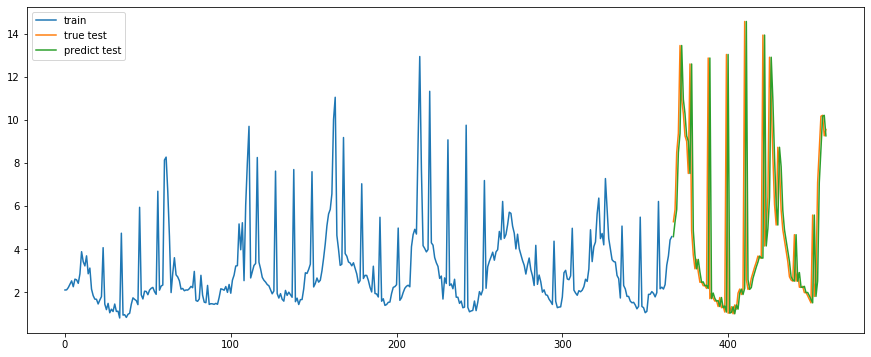

In [88]:
persistence('Texas')

In [476]:
persistence('New York', if_plot=False)

Test MSE:  2.7919943357116086


### Linear Autoregression

In [372]:
def auto_regression(state, window, if_plot=True):
    # split dataset
    X = flu_df[state].values
    size = int(len(X)*0.8) # 80% training
    train, test = X[:size], X[size:]
    
    # train
    model = AutoReg(train, lags=window).fit()
    coef = model.params
    
    # predict
    history = train[len(train)-window:].tolist()
    preds = []
    for t in range(len(test)):
        N = len(history)
        lag = [history[i] for i in range(N - window, N)]
        yhat = coef[0]
        
        for w in range(window):
            yhat += coef[w+1] * lag[window-w-1]
            
        preds.append(yhat)
        history.append(test[t])
        
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))
    
    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()      

Test RMSE:  2.475179397032585


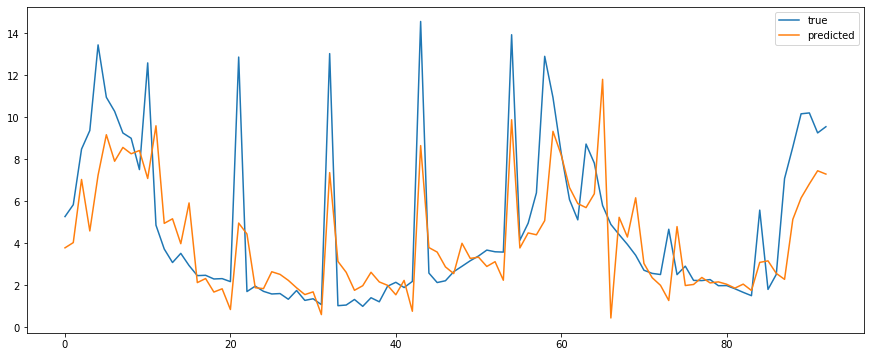

In [373]:
auto_regression('Texas', 15)

In [480]:
auto_regression('New York', 15, if_plot=False)

Test RMSE:  2.0117735842410793


### Linear Autoregression with Google Trend

###To do: ARGO

In [458]:
def ar_with_gt(df, lag, if_plot=True):
    # get train test
    flu, ft = pd.DataFrame(df.iloc[:, 1]), df.iloc[:, 2:]
    for i in range(lag):
        flu['lag {}'.format(i)] = flu.iloc[:, 0].shift(i+1)
    flu = flu.fillna(0) 
    
    X = pd.concat([flu.iloc[:, 1:], ft], axis = 1)
    y = flu.iloc[:, 0]
    
    size = int(len(df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    # model
    ridge = Ridge().fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE: ', rmse)
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
        
    return rmse

RMSE:  2.8711296534846933


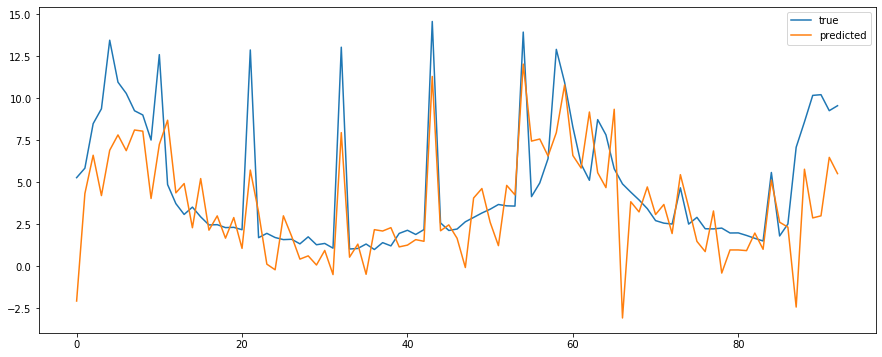

2.8711296534846933

In [459]:
ar_with_gt(df_texas, 52)

In [481]:
ar_with_gt(df_newyork, 52, if_plot=False)

RMSE:  2.3325840095745365


2.3325840095745365

### Linear Network Autoregression

In [389]:
def lnar(predict, target, lag, if_plot=True):
    # get train test
    y, predictors = flu_df[target], flu_df[predict]
    
    lag_series = []
    for i in range(lag):
        for col in predictors.columns:
            lag_series.append(predictors[col].shift(i+1).fillna(0))
    
    X = pd.concat(lag_series, axis = 1) 
    size = int(len(flu_df)*0.8) # 80% training
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    # model
    ridge = Ridge().fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE: ', rmse)
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
        
    return rmse

RMSE:  3.4766313820772288


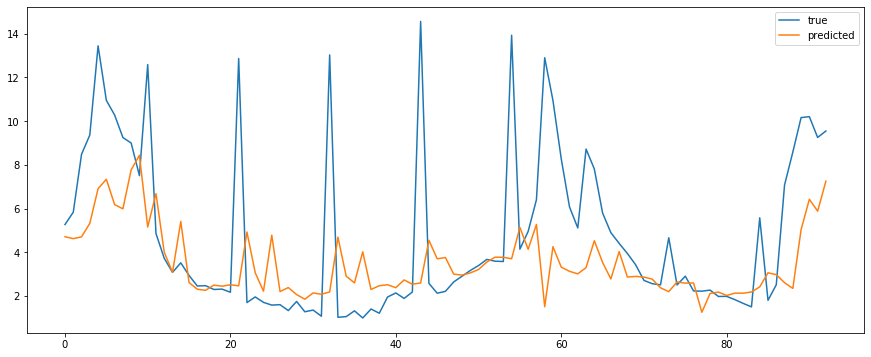

3.4766313820772288

In [397]:
# Use surrounding states as predictors
lnar(['New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas'], 'Texas', 4, if_plot=True)

In [483]:
# Use surrounding states as predictors
lnar(['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], 'New York', 4, if_plot=False)

RMSE:  2.262704055765882


2.262704055765882

### ARIMA

In [425]:
def arima(state, lag, if_plot=True):
    # split dataset
    X = flu_df[state].values
    size = int(len(X)*0.8) # 80% training
    train, test = X[:size], X[size:]
    
    # fit and predict
    history = train.tolist()
    preds = []
    for t in range(len(test)):
        model = ARIMA(history, order=(lag,1,5)).fit(disp=False)
        output = model.forecast()

        preds.append(output[0])
        history.append(test[t])
        
    print('Test RMSE: ', np.sqrt(mean_squared_error(test, preds)))
    
    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()      

Test RMSE:  3.1327863261058173


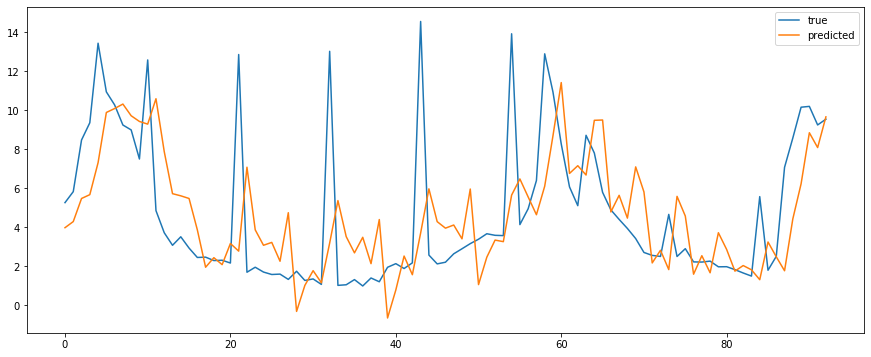

In [466]:
arima('Texas', 5)

### Random Forest

#### Without Google trend

In [484]:
X,y = flu_df[['New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas']], flu_df['Texas']
size = int(len(flu_df)*0.8) # 80% training
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

In [485]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

Test RMSE:  1.737816981544222


#### With Google trend

In [486]:
te = texas_google.copy()

In [487]:
# normalize google trend
for col in te.columns[1:]: 
    te[col] = (te[col]-te[col].min())/(te[col].max()-te[col].min())

In [488]:
X_df = flu_df[['date', 'New Mexico', 'Colorado', 'Oklahoma', 'Louisiana', 'Arkansas']].merge(te, 
                                                                                how = 'left', on='date').fillna(0)

X_gt = X_df.iloc[:, 1:]
size = int(len(flu_df)*0.8) # 80% training
X_train, X_test = X_gt[:size], X_gt[size:]
y_train, y_test = y[:size], y[size:]

In [489]:
rf = RandomForestRegressor(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))

Test RMSE:  1.7260638224103837


### RNN

#### Vanilla RNN

#### GRU

#### LSTM